<a href="https://colab.research.google.com/github/410650377/introduction-to-Computers/blob/main/Portfolio.Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investment Management: A Practical Guide to Portfolio Backtesting in Python

## Module 1: Introduction & Data Setup

Welcome to this practical guide on investment management. In this notebook, we will bridge the gap between raw financial data and robust portfolio strategies. We will move beyond simply "running a backtest" and learn the complete workflow used by quantitative portfolio managers.

Our goal is to test hypotheses based on well-known market "factors"—characteristics that may explain stock returns.

**Our Core Process:**
1.  **Signal Creation:** Define our investment factors (e.g., Value, Momentum, Size).
2.  **Factor Exploration:** Analyze the properties of these factors.
3.  **Backtesting:** Construct portfolios based on these factors and test their historical performance, including transaction costs.
4.  **Performance & Risk Analysis:** Go beyond simple returns to understand *why* our strategy performed the way it did, using tools like Alpha/Beta regression and drawdown analysis.
5.  **Multi-Factor Models:** Combine factors to build more sophisticated and robust portfolios—this will be your project.

Let's begin by loading our required libraries and pre-processed data.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm # New import for regression
import seaborn as sns # New import for plotting

# Setup plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'font.size': 12})

print("Libraries imported successfully.")

Libraries imported successfully.


In [24]:
# === Load preprocessed TEJ monthly file ===
try:
    df = pd.read_csv("twstock_monthly_2005_2024.csv", parse_dates=['date'])
    print(f"Loaded {df['stock_code'].nunique()} unique stocks and {len(df)} monthly records.")
    # Display the first few rows to confirm
    print(df.head())
except FileNotFoundError:
    print("Error: The file 'twstock_monthly_1990_202506.csv' was not found.")
    print("Please make sure the file is in the same directory as this notebook.")

Loaded 1211 unique stocks and 211732 monthly records.
        date  stock_code stock_name       RET       TOR       ME    PER   PBR  \
0 2005-01-31        1101         台泥 -0.038277  0.091584  0.00389  19.78  1.04   
1 2005-02-25        1101         台泥  0.004975  0.050366  0.00376  19.88  1.05   
2 2005-03-31        1101         台泥 -0.094060  0.106246  0.00351  18.01  0.95   
3 2005-04-29        1101         台泥  0.038253  0.059723  0.00376  18.70  0.98   
4 2005-05-31        1101         台泥 -0.060526  0.057039  0.00341  17.57  0.92   

    PRR    DY       HLD  
0  1.98  1.68  0.129187  
1  1.99  1.67  0.059701  
2  1.80  1.84  0.180693  
3  1.87  1.77  0.095628  
4  1.76  1.89  0.071053  


## Module 2: Factor Definition & Exploration

Before we build portfolios, we must define our "factors" (signals). In quantitative finance, the most famous factors are:

* **Value:** Are cheap stocks (e.g., low P/B, low P/E) better?
* **Momentum:** Do stocks that performed well recently continue to perform well?
* **Size:** Do smaller companies (low Market Cap) outperform larger ones?
* **Quality / Yield:** Do companies with strong fundamentals (e.g., high dividend yield) perform better?
* **Volatility:** Do low-volatility stocks (e.g., low high-low price difference) provide better risk-adjusted returns?

We will now create these signals from our base data.

**Crucial Note on Look-Ahead Bias:** We must `.shift(1)` our fundamental factors (like PBR, PER, ME) because the financial data for a given month (e.g., January 31st) is typically not released until *after* that date. We use the *previous* month's data to make decisions for the *current* month. Momentum is already backward-looking, so `.shift()` is applied differently.

In [25]:
# --- Create Trading Signals ---

# --- 1. Value Factors (Lagged one month) ---
df['PER_lag'] =df.groupby('stock_code')['PER'].shift(1)
df['PBR_lag'] =df.groupby('stock_code')['PBR'].shift(1)
df['DY_lag']  =df.groupby('stock_code')['DY'].shift(1)

In [26]:
# --- 2. Size Factor (Lagged one month) ---
df['ME_lag'] =df.groupby('stock_code')['ME'].shift(1)

In [27]:
# --- 3. Other Factors (for student projects) ---
df['TOR_lag'] =df.groupby('stock_code')['TOR'].shift(1)
df['HLD_lag'] =df.groupby('stock_code')['HLD'].shift(1)

In [28]:
df

,date,stock_code,stock_name,RET,TOR,ME,PER,PBR,PRR,DY,HLD,PER_lag,PBR_lag,DY_lag,ME_lag,TOR_lag,HLD_lag
0,2005-01-31,1101,台泥,-0.038277,0.091584,0.00389,19.78,1.04,1.98,1.68,0.129187,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-02-25,1101,台泥,0.004975,0.050366,0.00376,19.88,1.05,1.99,1.67,0.059701,19.78,1.04,1.68,0.00389,0.091584,0.129187
2,2005-03-31,1101,台泥,-0.094060,0.106246,0.00351,18.01,0.95,1.80,1.84,0.180693,19.88,1.05,1.67,0.00376,0.050366,0.059701
3,2005-04-29,1101,台泥,0.038253,0.059723,0.00376,18.70,0.98,1.87,1.77,0.095628,18.01,0.95,1.84,0.00351,0.106246,0.180693
4,2005-05-31,1101,台泥,-0.060526,0.057039,0.00341,17.57,0.92,1.76,1.89,0.071053,18.70,0.98,1.77,0.00376,0.059723,0.095628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211727,2024-08-30,9958,世紀鋼,0.096902,0.764808,0.00086,38.14,5.19,4.07,1.23,0.364465,35.25,4.80,1.33,0.00080,0.639311,0.306291
211728,2024-09-30,9958,世紀鋼,-0.065262,0.651962,0.00080,35.65,4.85,3.80,1.31,0.216842,38.14,5.19,1.23,0.00086,0.764808,0.364465
211729,2024-10-30,9958,世紀鋼,-0.067569,0.520037,0.00073,27.51,4.25,3.59,1.41,0.164414,35.65,4.85,1.31,0.00080,0.651962,0.216842
211730,2024-11-29,9958,世紀鋼,-0.154588,0.380752,0.00063,23.25,3.59,3.04,1.66,0.212560,27.51,4.25,1.41,0.00073,0.520037,0.164414


In [29]:
# --- 4. Momentum Factor ---
# Momentum: past 12-month cumulative return excluding last month (t-12 to t-2)
# This is the standard definition to avoid short-term reversal effects.
df['RET_shift1'] =df.groupby('stock_code')['RET'].shift(1)
# Calculate rolling 11-month return on the shifted (t-1) returns. This gives (t-2) to (t-12).
df['MOM11'] =df.groupby('stock_code')['RET_shift1'].rolling(11).sum().reset_index(level=0,drop=True)
df['MOM'] =df.groupby('stock_code')['MOM11'].shift(1)


In [30]:
df

,date,stock_code,stock_name,RET,TOR,ME,PER,PBR,PRR,DY,HLD,PER_lag,PBR_lag,DY_lag,ME_lag,TOR_lag,HLD_lag,RET_shift1,MOM11,MOM
0,2005-01-31,1101,台泥,-0.038277,0.091584,0.00389,19.78,1.04,1.98,1.68,0.129187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-02-25,1101,台泥,0.004975,0.050366,0.00376,19.88,1.05,1.99,1.67,0.059701,19.78,1.04,1.68,0.00389,0.091584,0.129187,-0.038277,NaN,NaN
2,2005-03-31,1101,台泥,-0.094060,0.106246,0.00351,18.01,0.95,1.80,1.84,0.180693,19.88,1.05,1.67,0.00376,0.050366,0.059701,0.004975,NaN,NaN
3,2005-04-29,1101,台泥,0.038253,0.059723,0.00376,18.70,0.98,1.87,1.77,0.095628,18.01,0.95,1.84,0.00351,0.106246,0.180693,-0.094060,NaN,NaN
4,2005-05-31,1101,台泥,-0.060526,0.057039,0.00341,17.57,0.92,1.76,1.89,0.071053,18.70,0.98,1.77,0.00376,0.059723,0.095628,0.038253,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211727,2024-08-30,9958,世紀鋼,0.096902,0.764808,0.00086,38.14,5.19,4.07,1.23,0.364465,35.25,4.80,1.33,0.00080,0.639311,0.306291,-0.273180,0.482375,0.755520
211728,2024-09-30,9958,世紀鋼,-0.065262,0.651962,0.00080,35.65,4.85,3.80,1.31,0.216842,38.14,5.19,1.23,0.00086,0.764808,0.364465,0.096902,0.448026,0.482375
211729,2024-10-30,9958,世紀鋼,-0.067569,0.520037,0.00073,27.51,4.25,3.59,1.41,0.164414,35.65,4.85,1.31,0.00080,0.651962,0.216842,-0.065262,0.551274,0.448026
211730,2024-11-29,9958,世紀鋼,-0.154588,0.380752,0.00063,23.25,3.59,3.04,1.66,0.212560,27.51,4.25,1.41,0.00073,0.520037,0.164414,-0.067569,0.380718,0.551274


In [31]:
# --- Winsorize factors to remove extreme outliers ---
# We clip factors at the 1st and 99th percentiles to avoid a single
# extreme (and likely erroneous) data point from dominating our portfolio.
print("Winsorizing factors to handle outliers...")
factors = ['PER_lag', 'PBR_lag', 'DY_lag', 'MOM', 'ME_lag', 'TOR_lag', 'HLD_lag']
for col in factors:
  df[col]=df[col].clip(df[col].quantile(0.01),df[col].quantile(0.99))

print("Factors ready for analysis.")
# Display descriptive statistics for our new factors
df[factors].describe().T

Winsorizing factors to handle outliers...
Factors ready for analysis.


,count,mean,std,min,25%,50%,75%,max
PER_lag,162207.0,28.028664,41.595997,4.350000,11.440000,16.080000,26.080000,304.488800
PBR_lag,206530.0,1.794403,1.445390,0.390000,0.910000,1.360000,2.110000,9.050000
DY_lag,209904.0,3.231397,2.883090,0.000000,0.120000,2.920000,5.090000,12.620000
MOM,197434.0,0.132604,0.391232,-0.771885,-0.094827,0.082924,0.310639,1.484530
ME_lag,200697.0,0.001002,0.002514,0.000020,0.000100,0.000240,0.000660,0.017740
TOR_lag,210520.0,0.142421,0.217070,0.001574,0.023595,0.060575,0.160662,1.292597
HLD_lag,209948.0,0.154205,0.103781,0.023645,0.081218,0.128806,0.197778,0.581621


### Factor Exploration: Correlation
Now that we have our factors, are they unique? Or are they all telling us the same thing? We can check by running a correlation heatmap.

* A high correlation (e.g., > 0.7 or < -0.7) between `PER_lag` and `PBR_lag` would suggest they are both capturing the same "Value" effect.
* A low correlation (e.g., near 0) between `PBR_lag` and `MOM` would be excellent. It suggests these factors are independent, and combining them could create a more diversified, robust strategy.

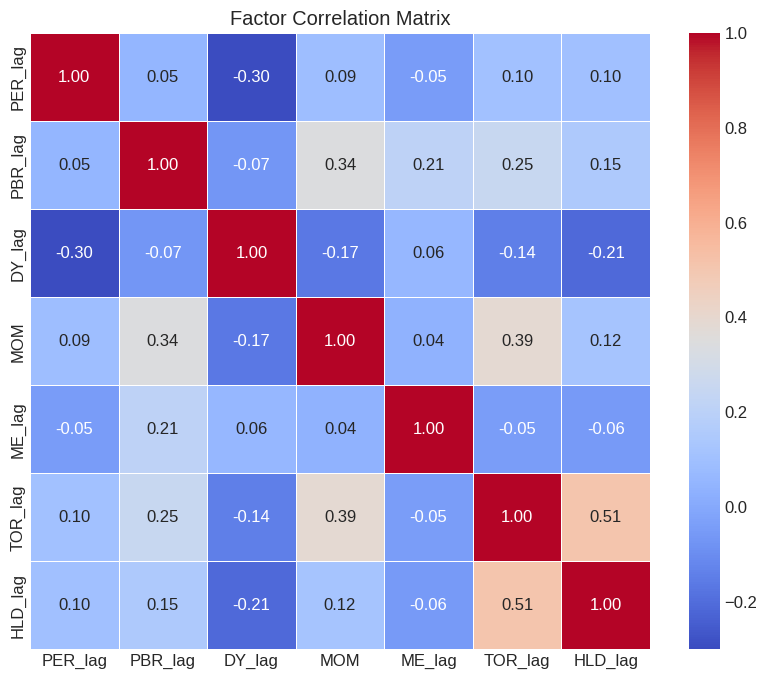

In [32]:
# --- Calculate and Plot Factor Correlation ---
factor_corr =df[factors].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(factor_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Factor Correlation Matrix')
plt.show()

**(Student Discussion):** Based on the heatmap, which factors are highly correlated? Which are most independent? How might this influence your decision when building a multi-factor portfolio?

## Module 3: Single-Factor Portfolio Backtesting

Now we define our core backtesting engine. This function is the heart of our notebook. It is designed to:
1.  **Rank:** Sort all stocks each month based on our chosen `signal`.
2.  **Select:** Choose the top 20% (`top_pct`) of stocks.
3.  **Weight:** Assign weights based on either Equal-Weight (EW) or Value-Weight (VW). VW (using `ME` for market cap) is more practical as it reflects the capacity of a strategy.
4.  **Calculate Returns:** Compute the portfolio's return for the *next* month.
5.  **Costs:** Calculate portfolio turnover and apply transaction costs (`cost_bps`) to get a "Net Return" series.

In [33]:
def backtest_portfolio(df, signal='PER_lag', top_pct=0.2, cost_bps=20, ascending=True, value_weight=False):
    """
    Sort stocks each month by the chosen signal and invest in the top group.
    Supports equal-weighted or value-weighted portfolio.
    """
    df_copy = df.copy()
    df_copy =df_copy.sort_values(['date','stock_code'])

    # --- Step 1: Rank by signal ---
    # We rank stocks every month based on the chosen signal
    df_copy['rank'] =df_copy.groupby('date')[signal].rank(pct=True,ascending=ascending)

    # --- Step 2: Select Portfolio ---
    # Select the top quintile (top 20%)
    df_copy['selected'] =np.where(df_copy['rank']>=(1-top_pct),1,0)

    # --- Step 3: Weighting scheme ---
    if value_weight:
        # Use ME (current market cap) for weighting, not ME_lag (which is the signal)
        # We assume ME is known at the time of portfolio construction (t)
        df_copy['w_raw'] =df_copy['selected']*df_copy['ME']
    else:
        # Equal weighting
        df_copy['w_raw'] =df_copy['selected']

    # Normalize weights to sum to 1
    df_copy['w_norm'] = df_copy.groupby('date')['w_raw'].transform(lambda x: x / x.sum() if x.sum() != 0 else 0)

    # --- Step 4: Calculate Portfolio Gross Return ---
    # We construct the portfolio at time (t) using signals from (t-1)
    # We hold this portfolio for the next month and capture the return (RET) at (t+1)
    # Therefore, we must shift our weights by 1 to align with the *next* month's RET
    df_copy['w_norm_lag'] =df_copy.groupby('stock_code')['w_norm'].shift(1)

    # Calculate gross return
    port_ret = df_copy.groupby('date', group_keys=False).apply(lambda x: np.sum(x['w_norm_lag'] * x['RET']))
    port_ret.name = 'GrossReturn'

    # --- Step 5: Turnover and Net Return ---
    # We need to pivot to get a (Date x Stock) matrix of weights
    df_unique = df_copy.drop_duplicates(subset=['date','stock_code'], keep='last')
    w = df_unique.pivot(index='date', columns='stock_code', values='w_norm').fillna(0)

    # Turnover is the sum of absolute changes in weights from (t-1) to (t), divided by 2 (buy + sell)
    turnover =(w-w.shift(1)).abs().sum(axis=1)/2

    # Transaction cost in basis points (e.g., 20bps = 0.0020)
    cost =turnover*(cost_bps/1000)

    # Net return is gross return minus costs
    # We align port_ret and cost, ensuring they are from the same period
    net_ret = (port_ret - cost).dropna()
    net_ret.name = 'NetReturn'

    df_out = pd.DataFrame({
        'GrossReturn': port_ret,
        'NetReturn': net_ret,
        'Turnover': turnover
    })
    df_out['Cumulative'] = (1 + df_out['NetReturn']).cumprod()
    return df_out

### Running the Backtests
Let's test three classic, long-only strategies:
1.  **Value (Low PBR):** Buy the cheapest 20% of stocks. `ascending=True`.
2.  **Momentum (High MOM):** Buy the 20% with the highest past returns. `ascending=False`.
3.  **Size (Small ME):** Buy the 20% smallest companies. `ascending=True`.

We will run each as Value-Weighted (VW) as it's more practical for a real fund.

In [34]:
# === 1. Run Factor Strategies (Value-Weighted) ===
print("Running backtests for Value, Momentum, and Size...")

# 1. Value Strategy (Low PBR)
res_pbr_vw =backtest_portfolio(df,signal='PBR_lag',ascending=False,top_pct=0.1,cost_bps=0,value_weight=True)

# 2. Momentum Strategy (High MOM)
res_mom_vw =backtest_portfolio(df,signal='MOM',ascending=True,top_pct=0.2,cost_bps=10,value_weight=True)

# 3. Size Strategy (Small ME)
res_size_vw =backtest_portfolio(df,signal='ME_lag',ascending=False,top_pct=0.25,cost_bps=20,value_weight=False)


Running backtests for Value, Momentum, and Size...


/tmp/ipython-input-4058836321.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_ret = df_copy.groupby('date', group_keys=False).apply(lambda x: np.sum(x['w_norm_lag'] * x['RET']))
/tmp/ipython-input-4058836321.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_ret = df_copy.groupby('date', group_keys=False).apply(lambda x: np.sum(x['w_norm_lag'] * x['RET']))
/tmp/ipython-input-4058836321.py:3

### Get Benchmark Data
No strategy is meaningful without a benchmark. We'll download the TAIEX (^TWII) to compare against.

In [35]:
# === 2. Download TWII Benchmark ===
print("Downloading TAIEX (^TWII) benchmark data...")
try:
    twii_close = yf.download("^TWII", start="2004-12-31", end="2025-01-01", progress=False)['Close']
    twii_m = twii_close.resample("ME").last() # 'ME' = Month-End frequency
    ret_twii = twii_m.pct_change().dropna()
    ret_twii.name = "TWII"
    print("Benchmark download complete.")
    print(ret_twii.head())
except Exception as e:
    print(f"Error downloading benchmark: {e}\nUsing placeholder data.")
    # Create a placeholder if download fails
    placeholder_index = res_pbr_vw.index
    ret_twii = pd.Series(np.random.normal(0.005, 0.05, len(placeholder_index)),
                         index=placeholder_index, name="TWII")

Benchmark download complete.
Ticker         ^TWII
Date                
2005-01-31 -0.023692
2005-02-28  0.035634
2005-03-31 -0.032532
2005-04-30 -0.031271
2005-05-31  0.033257


/tmp/ipython-input-930643606.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  twii_close = yf.download("^TWII", start="2004-12-31", end="2025-01-01", progress=False)['Close']


## Module 4: Deeper Performance & Risk Analysis

Now we define our `performance_report` function. This calculates the key metrics every portfolio manager reviews:
* **Annual Return:** The compounded average yearly return.
* **Annual Volatility:** The "risk" or choppiness of the returns.
* **Sharpe Ratio:** The risk-adjusted return. A higher Sharpe is better.
* **Max Drawdown:** The largest peak-to-trough loss. This is critical for understanding the "pain" of a strategy.

In [36]:
# === 3. Performance Summary Function ===
def performance_report(r):
    """
    Calculates key performance metrics for a return series.
    """
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return pd.Series({
            'Annual Return': np.nan, 'Annual Volatility': np.nan,
            'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan
        })

    # Annualized Return (Compounded)
    ann_ret =(1+r).prod()**(12/len(r))-1

    # Annualized Volatility
    ann_vol =r.std()*np.sqrt(12)

    # Sharpe Ratio (Risk-Free Rate = 0)
    # Use simple annualized mean return for Sharpe, as it's more intuitive
    sharpe =ann_ret/ann_vol

    # Cumulative Return & Max Drawdown
    cum =(1+r).cumprod()
    max_dd =(cum/cum.cummax()-1).min()

    return pd.Series({
        'Annual Return': ann_ret,
        'Annual Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    })

### 4a. Performance Summary Table
Let's compare the high-level statistics of our strategies against the benchmark.

In [37]:
# === 4. Performance Summary Table ===
perf_summary = pd.concat([
    performance_report(res_pbr_vw['NetReturn']).rename('Value (Low PBR)'),
    performance_report(res_mom_vw['NetReturn']).rename('Momentum (High MOM)'),
    performance_report(res_size_vw['NetReturn']).rename('Size (Small ME)'),
    performance_report(ret_twii.squeeze()).rename('TWII')
], axis=1)

# Display with percentage formatting and highlight the best in each row
display(perf_summary.style.format("{:.2%}").highlight_max(axis=1, color='lightgreen'))

,Value (Low PBR),Momentum (High MOM),Size (Small ME),TWII
Annual Return,12.02%,6.82%,13.52%,6.83%
Annual Volatility,25.75%,23.87%,23.02%,17.78%
Sharpe Ratio,46.68%,28.56%,58.74%,38.44%
Max Drawdown,-59.92%,-71.45%,-58.65%,-56.26%


### 4b. Cumulative Return Visualization
The summary table gives us the final numbers, but the *journey* matters. A log-scale cumulative return plot shows how these strategies evolved over time. A straight line on a log-scale plot indicates stable, compounded growth.

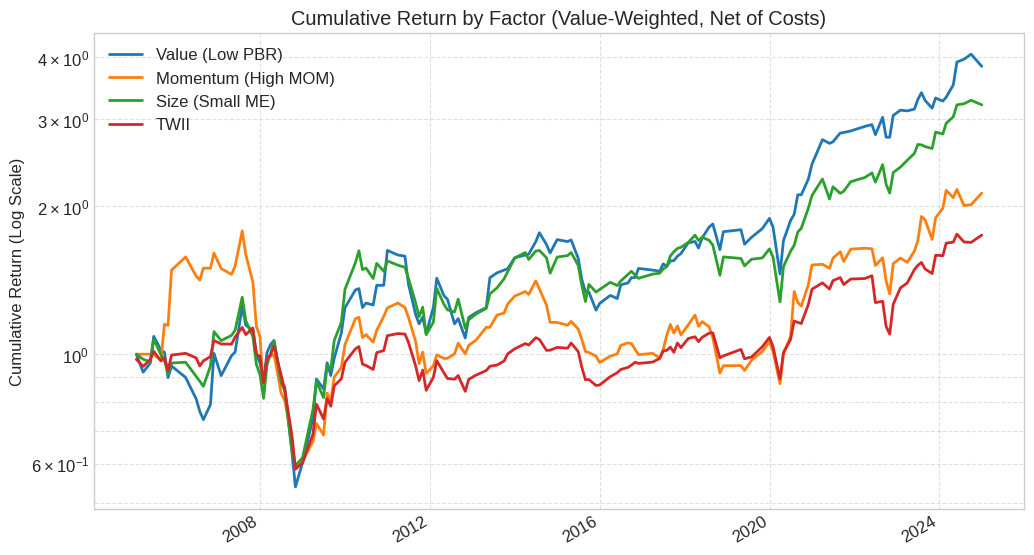

In [38]:
# === 5. Cumulative Return (Log-Scale Visualization) ===

# Find the common dates for all strategies and the benchmark
common_idx = res_pbr_vw.index.intersection(res_mom_vw.index)\
             .intersection(res_size_vw.index).intersection(ret_twii.index)

# Create cumulative return dataframe
cum_df = pd.concat([
    (1 + res_pbr_vw.loc[common_idx, 'NetReturn']).cumprod().rename('Value (Low PBR)'),
    (1 + res_mom_vw.loc[common_idx, 'NetReturn']).cumprod().rename('Momentum (High MOM)'),
    (1 + res_size_vw.loc[common_idx, 'NetReturn']).cumprod().rename('Size (Small ME)'),
    (1 + ret_twii.loc[common_idx, '^TWII']).cumprod().rename('TWII')
], axis=1)

# Plot
ax = cum_df.plot(title="Cumulative Return by Factor (Value-Weighted, Net of Costs)", lw=2, figsize=(12, 7))
ax.set_ylabel("Cumulative Return (Log Scale)")
ax.set_yscale("log")
ax.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()
plt.show()

### 4c. Portfolio Diagnostics: What Are We Holding?

A good portfolio manager doesn't just look at a performance chart; they need to know what they *actually own*. We will write a helper function to "look inside" our portfolio at any given date. This helps us check if the strategy is behaving as expected (e.g., is the "Low PBR" portfolio truly picking stocks we recognize as value stocks?).

We will re-run the ranking logic from our function for a *single date* to see the portfolio's top holdings.

In [39]:
def inspect_portfolio_at_date(df, target_date, signal, ascending, top_pct=0.2, value_weight=False):
    """
    Inspects the top holdings of a portfolio for a specific date.
    """
    df_copy = df.copy()

    # Find the data for the target month
    if isinstance(target_date, str):
        target_date = pd.to_datetime(target_date)

    # Get the data available *for* that date (which is the data *at* that date)
    monthly_data = df_copy[df_copy['date'] == target_date].dropna(subset=[signal, 'ME'])
    if monthly_data.empty:
        print(f"No data available for {target_date.strftime('%Y-%m-%d')}")
        return

    # --- Step 1: Rank by signal ---
    monthly_data['rank'] =monthly_data[signal].rank(pct=True,ascending=ascending)

    # --- Step 2: Select Portfolio ---
    monthly_data['selected'] =np.where(monthly_data['rank']>=(1-top_pct),1,0)

    # --- Step 3: Weighting ---
    portfolio = monthly_data[monthly_data['selected'] == 1].copy()
    if portfolio.empty:
        print(f"No stocks selected for {target_date.strftime('%Y-%m-%d')} with signal {signal}")
        return

    if value_weight:
        portfolio['w_raw'] = portfolio['selected'] * portfolio['ME']
    else:
        portfolio['w_raw'] = portfolio['selected']

    portfolio['Weight'] = portfolio['w_raw'] / portfolio['w_raw'].sum()

    # Display the top 10 holdings
    print(f"--- Top 10 Holdings for {signal} (Ascending={ascending}) on {target_date.strftime('%Y-%m-%d')} ---")
    print(f"Total stocks in portfolio: {len(portfolio)}")
    display(portfolio.sort_values('Weight', ascending=False).head(20)[['stock_code', 'stock_name', signal, 'ME', 'Weight']])

In [40]:
# --- Let's inspect our Value (Low PBR) portfolio on the most recent date ---
# Find the last available date in our dataframe that has PBR data
last_date = df.dropna(subset=['PBR_lag'])['date'].max()
inspect_portfolio_at_date(df,
             target_date=last_date,
             signal='PBR_lag',
             ascending=False,
             top_pct=0.2,
             value_weight=True)



--- Top 10 Holdings for PBR_lag (Ascending=False) on 2024-12-31 ---
Total stocks in portfolio: 198


,stock_code,stock_name,PBR_lag,ME,Weight
102774,2603,長榮,0.96,0.00661,0.085104
115276,2883,凱基金,0.97,0.00392,0.050470
103974,2609,陽明,0.86,0.00359,0.046221
7083,1303,南亞,0.83,0.00322,0.041457
105414,2615,萬海,1.02,0.00309,0.039784
6843,1301,台塑,0.77,0.00307,0.039526
116236,2887,台新金,1.01,0.00306,0.039397
116476,2888,新光金,0.76,0.00284,0.036565
109639,2801,彰銀,1.02,0.00271,0.034891
168081,5876,上海商銀,1.02,0.00261,0.033604


### 4d. Risk Analysis: Drawdowns and Rolling Performance

An annual return number hides the *experience* of holding the strategy. We must analyze its risk.

1.  **Drawdown:** How much did the strategy lose from its peak? This is the most important risk metric for many investors.
2.  **Rolling Return:** Was the strategy's performance consistent, or did it all come in one "lucky" year? We'll look at the 12-month rolling (moving) average return.
3.  **Rolling Sharpe Ratio:** This shows how the *risk-adjusted return* changed over time.

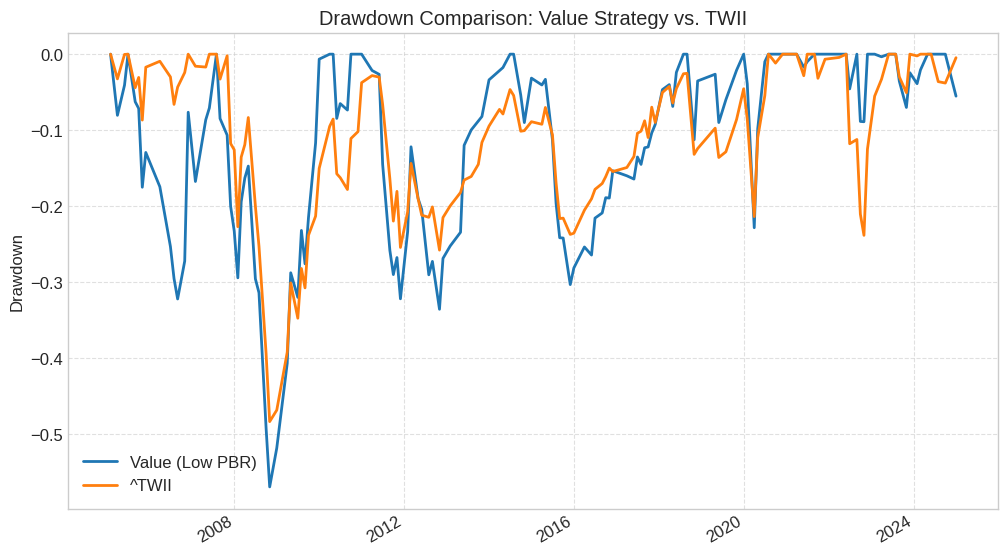

In [41]:
# --- 1. Drawdown Comparison ---
# (This code was in your original notebook and is excellent)

# Align all data first
common_idx = res_pbr_vw.index.intersection(ret_twii.index)
comparison_dd = pd.concat([
    res_pbr_vw.loc[common_idx, 'NetReturn'].rename('Value (Low PBR)'),
    ret_twii.loc[common_idx]
], axis=1).dropna()

# Calculate cumulative return
cum =(1+comparison_dd).cumprod()
# Calculate drawdown
drawdown =cum/cum.cummax()-1

# Plot
ax = drawdown.plot(title="Drawdown Comparison: Value Strategy vs. TWII", lw=2, figsize=(12, 7))
ax.set_ylabel("Drawdown")
ax.grid(True, which='both', ls='--', alpha=0.6)
plt.show()

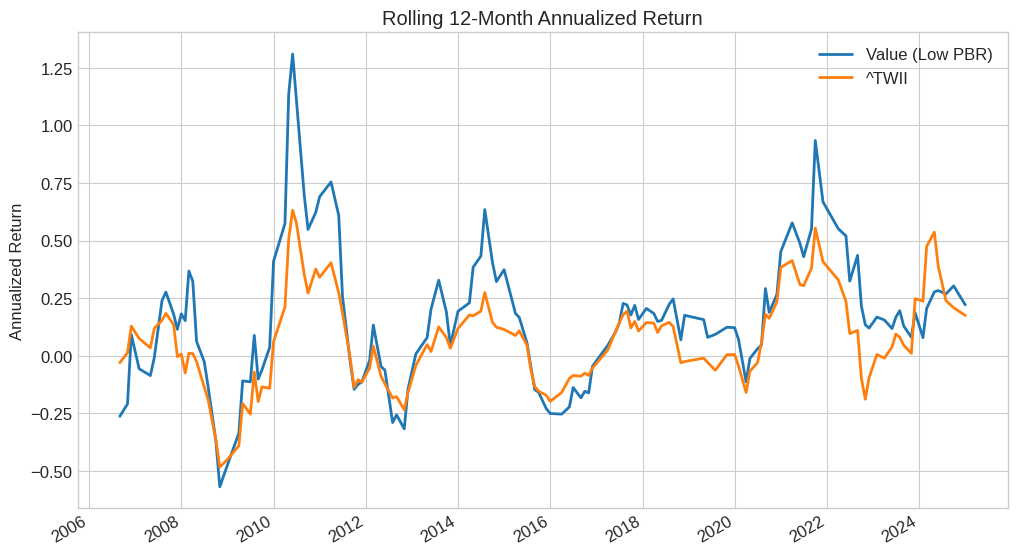

In [42]:
# --- 2. Rolling 12-Month Annualized Return ---
# (This code was in your original notebook)
window = 12
roll_ann =(1+comparison_dd).rolling(window).apply(lambda x:(x.prod())**(12/len(x))-1)

ax = roll_ann.plot(title="Rolling 12-Month Annualized Return", lw=2, figsize=(12, 7))
ax.set_ylabel("Annualized Return")
ax.grid(True)
plt.show()

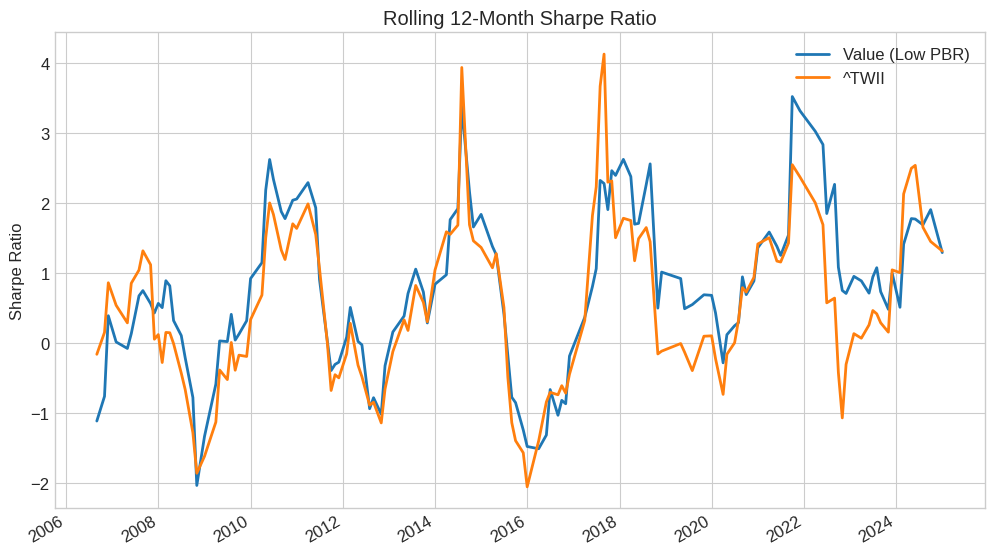

In [43]:
# --- 3. Rolling 12-Month Sharpe Ratio ---
# (This code was in your original notebook)
def rolling_sharpe(r, window=12):
    mean = r.rolling(window).mean() * 12
    vol = r.rolling(window).std() * np.sqrt(12)
    return mean / vol

roll_sharpe =comparison_dd.apply(lambda x:rolling_sharpe(x))

ax = roll_sharpe.plot(title="Rolling 12-Month Sharpe Ratio", lw=2, figsize=(12, 7))
ax.set_ylabel("Sharpe Ratio")
ax.grid(True)
plt.show()

### 4e. Turnover Analysis

Transaction costs are one of the biggest killers of strategy performance. **Turnover** measures how much we trade. A turnover of 0.5 (or 50%) means that over the period, 50% of the portfolio's value was bought or sold.

* High turnover (e.g., > 100% per month) is very expensive and can make a strategy unprofitable.
* Low turnover is generally preferred.

Our `backtest_portfolio` function already returns the turnover series. Let's plot it.

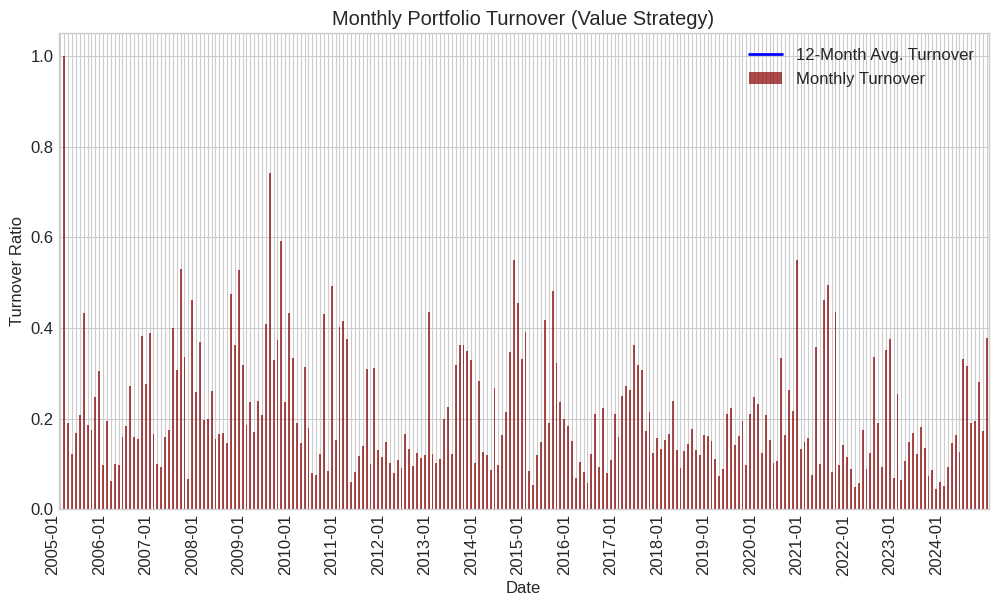

Average Annual Turnover: 253.20%
Median Monthly Turnover: 16.70%


In [44]:
# --- Plot Monthly Turnover for the Value Strategy ---
plt.figure(figsize=(12, 7))
res_pbr_vw['Turnover'].plot(kind='bar', color='darkred', alpha=0.7)

# Add a moving average to see the trend
res_pbr_vw['Turnover'].rolling(12).mean().plot(color='blue',lw=2)

plt.title('Monthly Portfolio Turnover (Value Strategy)')
plt.ylabel('Turnover Ratio')
plt.xlabel('Date')
# Improve x-axis labels: show only year starts
tick_labels = [item.strftime('%Y-%m') if item.month == 1 else '' for item in res_pbr_vw.index]
plt.xticks(ticks=range(len(tick_labels)), labels=tick_labels, rotation=90)
plt.legend(['12-Month Avg. Turnover', 'Monthly Turnover'])
plt.show()

print(f"Average Annual Turnover: {res_pbr_vw['Turnover'].mean() * 12:.2%}")
print(f"Median Monthly Turnover: {res_pbr_vw['Turnover'].median():.2%}")

**(Student Discussion):** Look at the turnover plot. Are there specific periods (like 2008 or 2020) where turnover spiked? Why do you think that is? (Hint: High market volatility can cause rankings to change rapidly). If our average *annual* turnover is 600%, it means we hold the average stock for only 2 months (12 / 6 = 2). Is this realistic?

## Module 5: Multi-Factor Portfolio Construction

This is where real-world portfolio management begins. Single factors can be unreliable. A "cheap" stock (Low PBR) might be cheap for a reason (it's a bad company).

We can build better portfolios by combining factors, as you requested. We'll test two professional methods.

### 5a. Method 1: The "Composite Score"
The simplest way to combine factors is to create a single "score."
1.  **Normalize:** We can't just add `PBR` (e.g., 1.5) and `MOM` (e.g., 0.12). We must first normalize them so they are on the same scale. We'll use a **Z-Score** (standard score), which measures how many standard deviations a stock is from the average.
2.  **Combine:** We can then add (or subtract) these scores. For example: `Value_Score + Momentum_Score`.
3.  **Backtest:** We run our standard `backtest_portfolio` function on this new `combo_signal`.

In [45]:
# === Project 1: Composite Score Backtest ===

def z_score_signal(df, signal):
    """Calculates the Z-score for a signal, grouped by date."""
    # Group by date, calculate z-score for the signal
    return df.groupby('date')[signal].transform(lambda x:(x-x.mean())/x.std())

# 1. Create normalized scores
# We want LOW PBR (so we multiply by -1 to make high scores good)
# We want HIGH MOM (so we multiply by +1)
df['PBR_z'] =z_score_signal(df,'PBR_lag')*(-1)
df['MOM_z'] =z_score_signal(df,'MOM')

# 2. Create composite signal (equal weight)
df['combo_signal'] =df['PBR_z']+df['MOM_z']

print("Composite Signal (PBR_z + MOM_z) Created.")

Composite Signal (PBR_z + MOM_z) Created.


In [46]:
# 3. Run backtest (we want the HIGHEST composite score)
res_combo_vw = backtest_portfolio(df, signal='combo_signal', ascending=True,
                                  top_pct=0.2, cost_bps=10, value_weight=True)

# 4. Run performance analysis
combo_vs_twii = pd.concat([
    performance_report(res_combo_vw['NetReturn']).rename('Composite (Val+Mom)'),
    performance_report(ret_twii.squeeze()).rename('TWII')
], axis=1)

print("--- Performance of Composite Score Strategy ---")
display(combo_vs_twii.style.format("{:.2%}").highlight_max(axis=1, color='lightgreen'))

--- Performance of Composite Score Strategy ---


/tmp/ipython-input-4058836321.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_ret = df_copy.groupby('date', group_keys=False).apply(lambda x: np.sum(x['w_norm_lag'] * x['RET']))


,Composite (Val+Mom),TWII
Annual Return,8.67%,6.83%
Annual Volatility,23.94%,17.78%
Sharpe Ratio,36.23%,38.44%
Max Drawdown,-66.35%,-56.26%


### 5b. Method 2: The "Sequential Sort"
This is a very practical, "real-world" method that directly applies **multiple conditions**.

The logic is: "I don't want all cheap stocks. I want a *universe* of cheap stocks, and *then* I'll pick the ones with high momentum from that universe."

1.  **Filter 1 (Universe):** First, we rank by `PBR_lag` and keep only the cheapest 30% (the "Value" universe).
2.  **Filter 2 (Selection):** Second, *within that 30% group*, we rank by `MOM` and buy the top 20% (the "Value + Momentum" picks).

This requires a new backtesting function.

In [47]:
# === Project 2: Sequential Sort Backtest Function ===

def backtest_sequential_sort(df, signal_1, signal_1_pct, signal_1_asc,
                             signal_2, signal_2_pct, signal_2_asc,
                             cost_bps=20, value_weight=False):
    """
    Backtests a sequential sort.
    1. Filters by signal_1 (e.g., cheapest 30% PBR)
    2. Sorts the remainder by signal_2 (e.g., highest 20% MOM)
    """
    df_copy = df.copy()
    df_copy = df_copy.sort_values(['date','stock_code'])

    # --- Step 1: First Sort (Universe Filter) ---
    df_copy['rank_1'] = df_copy.groupby('date')[signal_1].rank(pct=True, ascending=signal_1_asc)
    df_copy['universe'] = np.where(df_copy['rank_1'] >= (1 - signal_1_pct), 1, 0)

    # --- Step 2: Second Sort (Selection) ---
    # Rank signal 2 ONLY within the universe
    # Set non-universe signals to NaN so they are ignored by the ranker
    df_copy[signal_2] = df_copy[signal_2].where(df_copy['universe'] == 1)
    df_copy['rank_2'] = df_copy.groupby('date')[signal_2].rank(pct=True, ascending=signal_2_asc)

    # Select the top pct from the second sort
    df_copy['selected'] = np.where(df_copy['rank_2'] >= (1 - signal_2_pct), 1, 0)

    # --- Steps 3, 4, 5 (Weighting, Returns, Costs) are the same as before ---
    if value_weight:
        df_copy['w_raw'] = df_copy['selected'] * df_copy['ME']
    else:
        df_copy['w_raw'] = df_copy['selected']

    df_copy['w_norm'] = df_copy.groupby('date')['w_raw'].transform(lambda x: x / x.sum() if x.sum() != 0 else 0)
    df_copy['w_norm_lag'] = df_copy.groupby('stock_code')['w_norm'].shift(1)
    port_ret = df_copy.groupby('date', group_keys=False).apply(lambda x: np.sum(x['w_norm_lag'] * x['RET']))
    port_ret.name = 'GrossReturn'

    df_unique = df_copy.drop_duplicates(subset=['date','stock_code'], keep='last')
    w = df_unique.pivot(index='date', columns='stock_code', values='w_norm').fillna(0)
    turnover = (w - w.shift(1)).abs().sum(axis=1) / 2
    cost = turnover * (cost_bps / 1e4)
    net_ret = (port_ret - cost).dropna()
    net_ret.name = 'NetReturn'

    df_out = pd.DataFrame({'NetReturn': net_ret, 'Turnover': turnover})
    return df_out

In [48]:
# --- Run the Sequential Sort ---
print("Running Sequential Sort (Value then Momentum)...")
# 1. Filter: Top 30% cheapest stocks (PBR_lag, ascending=True, pct=0.3)
# 2. Select: From those 30%, pick Top 20% highest momentum (MOM, ascending=False, pct=0.2)
res_seq_ew =backtest_sequential_sort(df,
                   signal_1='PBR_lag',
                   signal_1_pct=0.1,
                   signal_1_asc=False,
                   signal_2='MOM',
                   signal_2_pct=0.1,
                   signal_2_asc=True,
                   cost_bps=20,
                   value_weight=True)

Running Sequential Sort (Value then Momentum)...


/tmp/ipython-input-2929857387.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_ret = df_copy.groupby('date', group_keys=False).apply(lambda x: np.sum(x['w_norm_lag'] * x['RET']))


In [49]:
# 4. Run performance analysis
seq_vs_twii = pd.concat([
    performance_report(res_seq_ew['NetReturn']).rename('Sequential (Val then Mom)'),
    performance_report(ret_twii.squeeze()).rename('TWII')
], axis=1)

print("--- Performance of Sequential Sort Strategy ---")
display(seq_vs_twii.style.format("{:.2%}").highlight_max(axis=1, color='lightgreen'))

--- Performance of Sequential Sort Strategy ---


,Sequential (Val then Mom),TWII
Annual Return,9.54%,6.83%
Annual Volatility,30.14%,17.78%
Sharpe Ratio,31.67%,38.44%
Max Drawdown,-68.95%,-56.26%


### 5c. Visualizing the Multi-Factor Results

Let's compare our new multi-factor strategies against the single-factor ones and the benchmark.

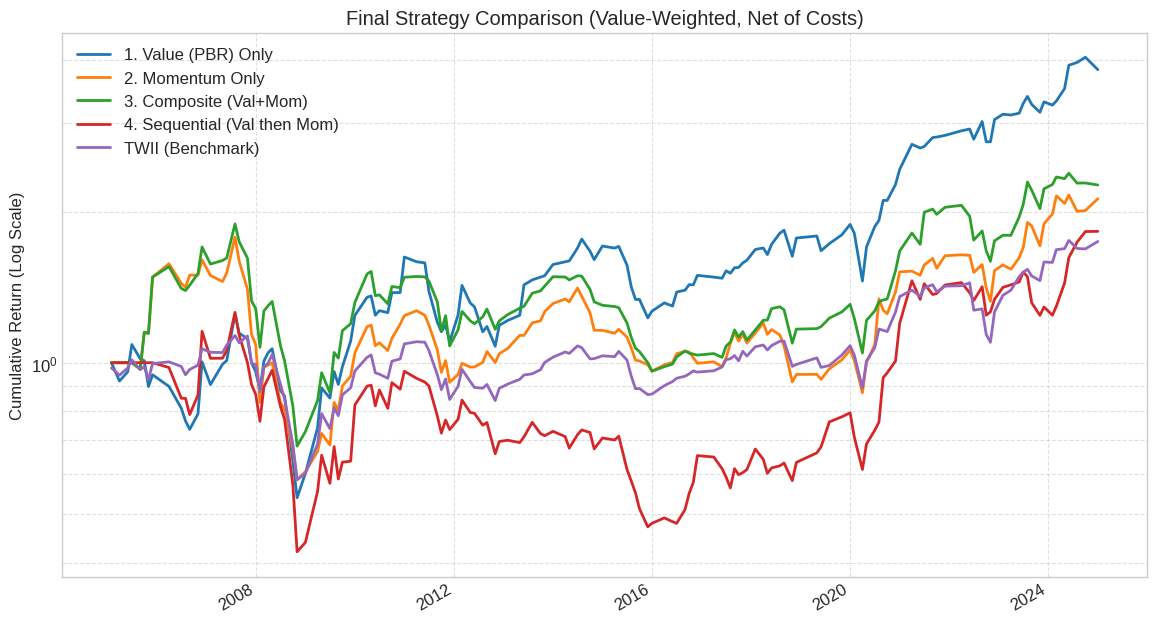

In [50]:
# === 6. Plot all strategies together ===

# Find the common dates for all strategies
common_idx_all = res_pbr_vw.index.intersection(res_mom_vw.index)\
                 .intersection(res_combo_vw.index).intersection(res_seq_ew.index)\
                 .intersection(ret_twii.index)

# Create cumulative return dataframe
cum_all_df = pd.concat([
    (1 + res_pbr_vw.loc[common_idx_all, 'NetReturn']).cumprod().rename('1. Value (PBR) Only'),
    (1 + res_mom_vw.loc[common_idx_all, 'NetReturn']).cumprod().rename('2. Momentum Only'),
    (1 + res_combo_vw.loc[common_idx_all, 'NetReturn']).cumprod().rename('3. Composite (Val+Mom)'),
    (1 + res_seq_ew.loc[common_idx_all, 'NetReturn']).cumprod().rename('4. Sequential (Val then Mom)'),
    (1 + ret_twii.loc[common_idx_all, '^TWII']).cumprod().rename('TWII (Benchmark)')
], axis=1)

# Plot
ax = cum_all_df.plot(title="Final Strategy Comparison (Value-Weighted, Net of Costs)",
                     lw=2, figsize=(14, 8))
ax.set_ylabel("Cumulative Return (Log Scale)")
ax.set_yscale("log")
ax.grid(True, which='both', ls='--', alpha=0.6)
plt.legend(loc='best')
plt.show()

## Module 6: Student Project Zone - Design Your Own Strategy

This is your chance to be the Portfolio Manager. You will now design, build, and test your *own* strategy using the tools we've developed.

### Your Task:
Follow these steps to create and present your unique portfolio strategy.

**Step 1: Formulate a Hypothesis.**
What do you believe drives returns?
* *Example 1 (Value):* "I believe cheap stocks (Low PBR) that also have high dividend yields (High DY) will outperform."
* *Example 2 (Low Volatility):* "I believe stocks with low recent volatility (Low HLD_lag) will have better risk-adjusted returns."
* *Example 3 (Liquidity):* "I believe stocks that are *less* traded (Low TOR_lag) are overlooked and will outperform."

**Step 2: Choose Your Factors.**
Select from the factors we have available:
* **Value:** `PER_lag` (Low), `PBR_lag` (Low), `DY_lag` (High)
* **Momentum:** `MOM` (High)
* **Size:** `ME_lag` (Low)
* **Volatility:** `HLD_lag` (Low)
* **Liquidity:** `TOR_lag` (Low or High?)

**Step 3: Choose Your Method (Method 1 or Method 2).**
* **Method 1 (Composite):** Create Z-scores for your chosen factors (like we did for `PBR_z` and `MOM_z`) and combine them into a `my_signal`.
* **Method 2 (Sequential):** Use `backtest_sequential_sort`. First, filter for a broad universe (e.g., `signal_1='ME_lag', signal_1_pct=0.5, signal_1_asc=True` to get the smallest 50% of stocks). Then, select from that universe using your main factor (e.g., `signal_2='MOM', signal_2_pct=0.2, signal_2_asc=False`).

**Step 4: Run Your Backtest.**
* Call either `backtest_portfolio` or `backtest_sequential_sort` with your new signals.
* **Crucially, decide on `value_weight=True` (more practical) or `value_weight=False` (tests the pure signal).**
* **Justify your `cost_bps`.** 20bps (0.20%) is standard. If your strategy trades a lot (high turnover), you might test it with `cost_bps=30` or `cost_bps=50`.

**Step 5: Analyze Your Results.**
You must present *at minimum*:
1.  **Performance Summary:** The table from `performance_report` comparing your strategy to `TWII`.
2.  **Cumulative Return Plot:** The log-scale plot comparing your strategy to `TWII`.
3.  **Turnover & Drawdown:** Analyze the `Turnover` plot and `Drawdown` plot. Is the risk acceptable? Are the costs realistic?
4.  **Portfolio Inspection:** Use `inspect_portfolio_at_date` for a recent date. Are the stocks in your portfolio what you expected?

---
### Project Example: "Low Volatility" Strategy
Here is a quick example of a simple "Low Volatility" strategy.

* **Hypothesis:** Stocks with lower price volatility (a "Quality" or "Safety" metric) provide better, smoother returns.
* **Factor:** `HLD_lag` (High-Low % Difference)
* **Direction:** We want the *lowest* HLD, so we will use `ascending=True`.

Running Low Volatility (Low HLD_lag) Strategy...

--- Performance of Low Volatility Strategy ---


/tmp/ipython-input-4058836321.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_ret = df_copy.groupby('date', group_keys=False).apply(lambda x: np.sum(x['w_norm_lag'] * x['RET']))


,Low Volatility,TWII
Annual Return,-2.22%,6.83%
Annual Volatility,13.32%,17.78%
Sharpe Ratio,-16.67%,38.44%
Max Drawdown,-52.66%,-56.26%


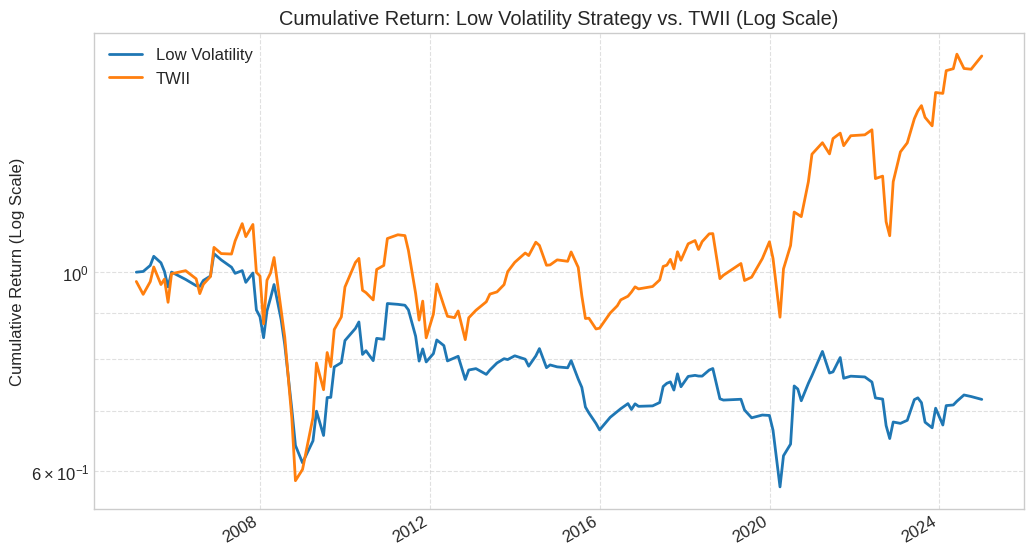

In [51]:
#範例
# === Student Project Example: Low Volatility ===

# 1. & 2. Hypothesis and Factor are defined above.
# 3. Method: Simple single-factor
# 4. Run Backtest:
print("Running Low Volatility (Low HLD_lag) Strategy...")
res_low_vol = backtest_portfolio(df,
                                 signal='HLD_lag',
                                 ascending=False,  # We want *low* volatility
                                 top_pct=0.2,
                                 cost_bps=20,
                                 value_weight=True)

# 5. Analyze Results:
print("\n--- Performance of Low Volatility Strategy ---")
perf_low_vol = pd.concat([
    performance_report(res_low_vol['NetReturn']).rename('Low Volatility'),
    performance_report(ret_twii.squeeze()).rename('TWII')
], axis=1)
display(perf_low_vol.style.format("{:.2%}").highlight_max(axis=1, color='lightgreen'))

# --- Plot Cumulative Return ---
common_idx_vol = res_low_vol.index.intersection(ret_twii.index)
cum_vol_df = pd.concat([
    (1 + res_low_vol.loc[common_idx_vol, 'NetReturn']).cumprod().rename('Low Volatility'),
    (1 + ret_twii.loc[common_idx_vol, '^TWII']).cumprod().rename('TWII')
], axis=1)

ax = cum_vol_df.plot(title="Cumulative Return: Low Volatility Strategy vs. TWII (Log Scale)", lw=2, figsize=(12, 7))
ax.set_ylabel("Cumulative Return (Log Scale)")
ax.set_yscale("log")
ax.grid(True, which='both', ls='--', alpha=0.6)
plt.legend(loc='best')
plt.show()

### Your Project Space
Use the cells below to build and test your own strategy!

,Value (Low PBR),Momentum (High MOM),Size (Small ME),TWII
Annual Return,12.02%,6.82%,13.52%,6.83%
Annual Volatility,25.75%,23.87%,23.02%,17.78%
Sharpe Ratio,46.68%,28.56%,58.74%,38.44%
Max Drawdown,-59.92%,-71.45%,-58.65%,-56.26%


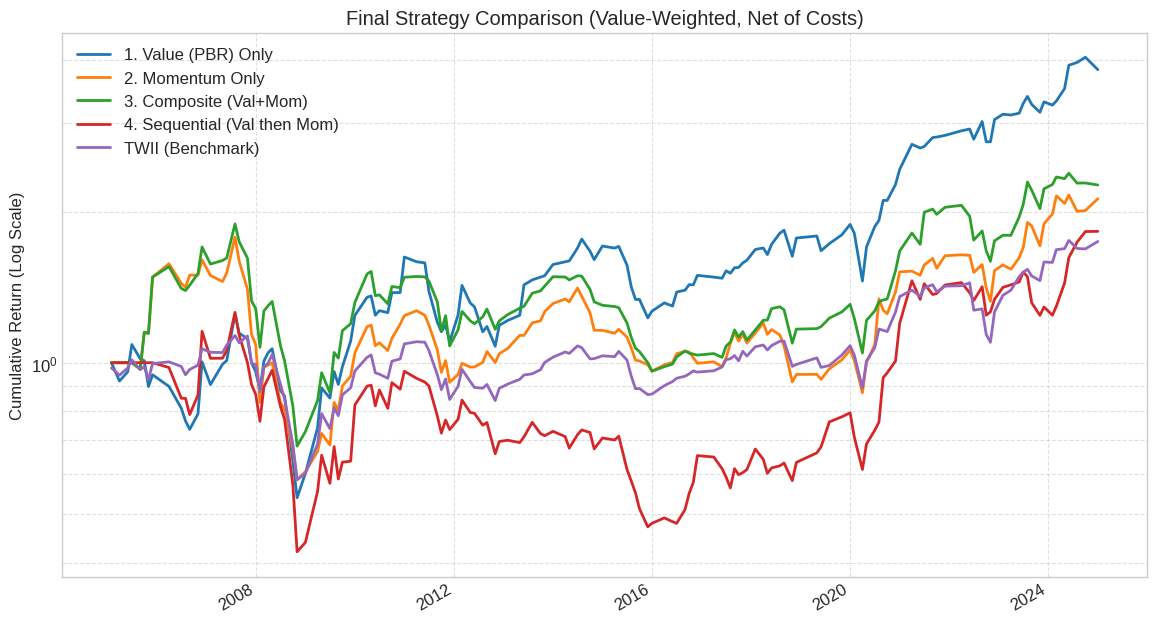

Running High Dividend + Value Strategy...

--- Performance of High Dividend + Value Strategy ---


/tmp/ipython-input-4058836321.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_ret = df_copy.groupby('date', group_keys=False).apply(lambda x: np.sum(x['w_norm_lag'] * x['RET']))


,High DY + Value,TWII
Annual Return,9.47%,6.83%
Annual Volatility,21.15%,17.78%
Sharpe Ratio,44.76%,38.44%
Max Drawdown,-65.69%,-56.26%


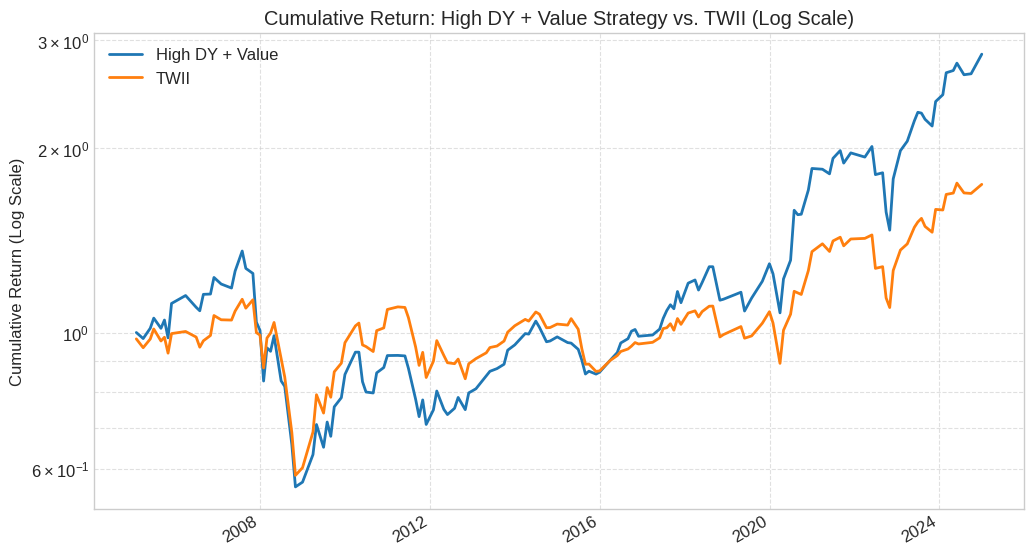

In [52]:
# 1. Performance Summary of Basic Factors(Maxdd,Vol越小越好)

perf_summary = pd.concat([
    performance_report(res_pbr_vw['NetReturn']).rename('Value (Low PBR)'),
    performance_report(res_mom_vw['NetReturn']).rename('Momentum (High MOM)'),
    performance_report(res_size_vw['NetReturn']).rename('Size (Small ME)'),
    performance_report(ret_twii.squeeze()).rename('TWII')
], axis=1)

display(
    perf_summary.style
    .format("{:.2%}")
    .highlight_max(axis=1, color='lightgreen')
)
common_idx_all = res_pbr_vw.index.intersection(res_mom_vw.index)\
                 .intersection(res_combo_vw.index).intersection(res_seq_ew.index)\
                 .intersection(ret_twii.index)

# Create cumulative return dataframe
cum_all_df = pd.concat([
    (1 + res_pbr_vw.loc[common_idx_all, 'NetReturn']).cumprod().rename('1. Value (PBR) Only'),
    (1 + res_mom_vw.loc[common_idx_all, 'NetReturn']).cumprod().rename('2. Momentum Only'),
    (1 + res_combo_vw.loc[common_idx_all, 'NetReturn']).cumprod().rename('3. Composite (Val+Mom)'),
    (1 + res_seq_ew.loc[common_idx_all, 'NetReturn']).cumprod().rename('4. Sequential (Val then Mom)'),
    (1 + ret_twii.loc[common_idx_all, '^TWII']).cumprod().rename('TWII (Benchmark)')
], axis=1)

# Plot
ax = cum_all_df.plot(title="Final Strategy Comparison (Value-Weighted, Net of Costs)",
                     lw=2, figsize=(14, 8))
ax.set_ylabel("Cumulative Return (Log Scale)")
ax.set_yscale("log")
ax.grid(True, which='both', ls='--', alpha=0.6)
plt.legend(loc='best')
plt.show()


# 3. High Dividend + Value Strategy[高殖利率（DY_lag） 與 低股價淨值比（PBR_lag）]

print("Running High Dividend + Value Strategy...")


df['DY_z']  = df.groupby('date')['DY_lag'] .transform(lambda x: (x - x.mean()) / x.std())
df['PBR_z'] = df.groupby('date')['PBR_lag'].transform(lambda x: -(x - x.mean()) / x.std())

df['my_signal'] = df['DY_z'] + df['PBR_z']


res_dy_value = backtest_portfolio(
    df=df,
    signal='my_signal',
    ascending=False,
    top_pct=0.2,
    cost_bps=20,
    value_weight=True
)


print("\n--- Performance of High Dividend + Value Strategy ---")

perf_dy_value = pd.concat([
    performance_report(res_dy_value['NetReturn']).rename('High DY + Value'),
    performance_report(ret_twii.squeeze()).rename('TWII')
], axis=1)

display(
    perf_dy_value.style
    .format("{:.2%}")
    .highlight_max(axis=1, color='lightgreen')
)



# 4. Cumulative Return Plot

common_idx = res_dy_value.index.intersection(ret_twii.index)

twii_col = ret_twii.columns[0]

cum_ret_df = pd.concat([
    (1 + res_dy_value.loc[common_idx, 'NetReturn']).cumprod().rename('High DY + Value'),
    (1 + ret_twii.loc[common_idx, twii_col]).cumprod().rename('TWII')
], axis=1)

ax = cum_ret_df.plot(
    title="Cumulative Return: High DY + Value Strategy vs. TWII (Log Scale)",
    lw=2,
    figsize=(12, 7)
)
ax.set_ylabel("Cumulative Return (Log Scale)")
ax.set_yscale("log")
ax.grid(True, which='both', ls='--', alpha=0.6)
plt.legend(loc='best')
plt.show()
